# Look! It's a Bird! It's a Plane! It's an Exoplanet!
Machine Learning to Determine Exoplanet Classification

## Data

### Source:
NASA exoplanet data set from kaggle. Updated as of June 2022.
https://www.kaggle.com/datasets/arashnic/exoplanets

### Goal:
Build model to predict if an observation is a planet

### EDA

In [4]:
# load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import scatterplot

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load data
kp = pd.read_csv('/content/drive/MyDrive/ADS-504/Project/exoplanets.csv')
kp.shape

(9564, 49)

In [ ]:
kp.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


We're looking to predict (target variable) disposition, so our first check is to see what the disposition count looks like.

#### Target Variable Determination

In [ ]:
kp['koi_disposition'].value_counts()

FALSE POSITIVE    4840
CANDIDATE         2367
CONFIRMED         2357
Name: koi_disposition, dtype: int64

In [ ]:
kp['koi_pdisposition'].value_counts()

FALSE POSITIVE    4847
CANDIDATE         4717
Name: koi_pdisposition, dtype: int64

We can visualize in a bar chart as well.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


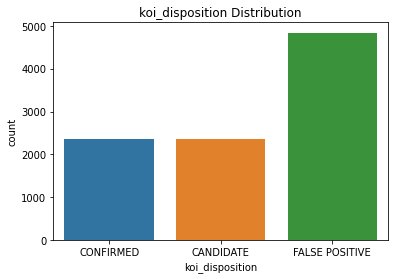

In [ ]:
sns.countplot(kp['koi_disposition'])
plt.title('koi_disposition Distribution');

The large number of false positives may be something to deal with in preprocessing.  We can treat this as a binary classification problem, or we can do a multiclass prediction, and include predicting the data will classify certain observations as false positives.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


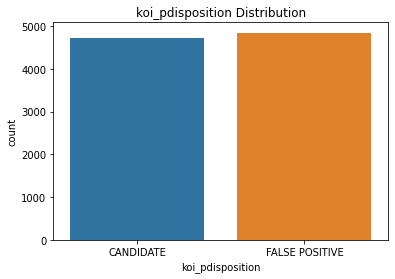

In [ ]:
sns.countplot(kp['koi_pdisposition'])
plt.title('koi_pdisposition Distribution');

In [ ]:
pd.DataFrame(kp['koi_score'].describe())

,koi_score
count,8054.000000
mean,0.480829
std,0.476928
min,0.000000
25%,0.000000
50%,0.334000
75%,0.998000
max,1.000000


koi_score looks to be used for assigning candidates and confirmations.  This should be left out of the model, as it will probably drive the predictions.

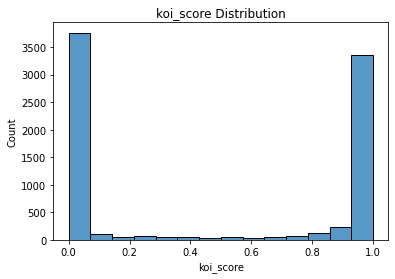

In [ ]:
sns.histplot(kp['koi_score'])
plt.title('koi_score Distribution')
plt.show()

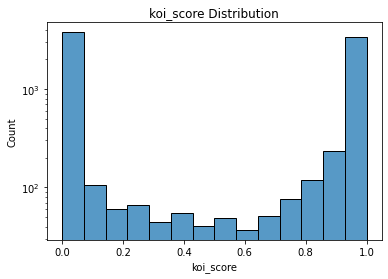

In [ ]:
# let's scale the counts to better see the distributions in the center
sns.histplot(kp['koi_score'])
plt.title('koi_score Distribution')
plt.gca().set_yscale('log')
plt.show()

Text(0.5, 1.0, 'koi_score Distribution Over koi_disposition')

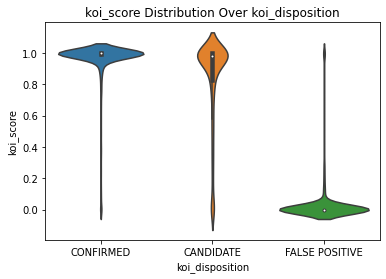

In [ ]:
# let's see how our three target variable candidates compare against each other
sns.violinplot(data=kp, x='koi_disposition', y='koi_score')
plt.title('koi_score Distribution Over koi_disposition')

Text(0.5, 1.0, 'koi_score Distribution Over koi_pdisposition')

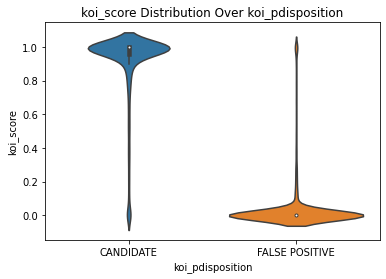

In [ ]:
sns.violinplot(data=kp, x='koi_pdisposition', y='koi_score')
plt.title('koi_score Distribution Over koi_pdisposition')

As suspected, a numerical koi_score of 1 highly correlates to koi_disposition and koi_pdisposition that categorizes an observation as a planet or planet candidate, while a numerical koi_score of 0 highly correlates to a false positive for koi_disposition and koi_pdisposition. koi_score will be excluded from our model as a predictor variable.

koi_disposition was the derived archival categorisation while koi_pdisposition uses the newer Kepler data for categorisation. As we will be working with data collected from the Kepler mission, koi_pdisposition will be used as our target variable.

#### Feature Reduction

Handling missing Data

In [ ]:
#Find rows with missing data.
kp.isnull().sum()

kepid                   0
kepoi_name              0
kepler_name          7205
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_er

Our focus for the predictor variables will be the data measured by Kepler, so we'll remove any derived data from the measurements. This includes nomenclature as well as variables consisting of all missing observations.

In [ ]:
kp_df = pd.DataFrame(kp).drop(kp[['kepoi_name','kepid', 'kepler_name','koi_disposition', 'koi_score', 'koi_fpflag_nt', 
                                  'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_teq_err1', 'koi_teq_err2', 'koi_tce_delivname']], axis = 1)

In [ ]:
kp_df.isnull().sum()

koi_pdisposition       0
koi_period             0
koi_period_err1      454
koi_period_err2      454
koi_time0bk            0
koi_time0bk_err1     454
koi_time0bk_err2     454
koi_impact           363
koi_impact_err1      454
koi_impact_err2      454
koi_duration           0
koi_duration_err1    454
koi_duration_err2    454
koi_depth            363
koi_depth_err1       454
koi_depth_err2       454
koi_prad             363
koi_prad_err1        363
koi_prad_err2        363
koi_teq              363
koi_insol            321
koi_insol_err1       321
koi_insol_err2       321
koi_model_snr        363
koi_tce_plnt_num     346
koi_steff            363
koi_steff_err1       468
koi_steff_err2       483
koi_slogg            363
koi_slogg_err1       468
koi_slogg_err2       468
koi_srad             363
koi_srad_err1        468
koi_srad_err2        468
ra                     0
dec                    0
koi_kepmag             1
dtype: int64

We'll look at the impact of dropping the rows with missing data on the size of the data set.

In [ ]:
kp_drop = kp_df.dropna()
kp_drop.shape

(8744, 37)

(820, 37)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

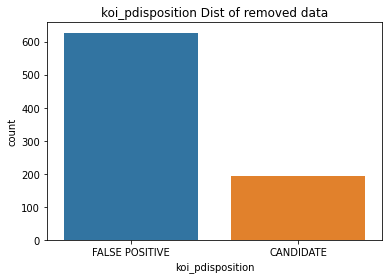

In [ ]:
null_data = kp_df[kp_df.isnull().any(axis=1)]
print(null_data.shape)
sns.countplot(null_data['koi_pdisposition'])
plt.title('koi_pdisposition Dist of removed data')
plt.show

There are 820 rows with missing data, which comprises less than 10% of the total data set.  Further, of the rows with missing data, over 600 of the 820 are false positives.  This suggests missing data is likely to lead to a false positive.  Another way to look at it may be that the missing data is biasing the model to a false positive.  Rather than imputing, which may still drive bias into the data set, we decided to remove the rows with missing data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

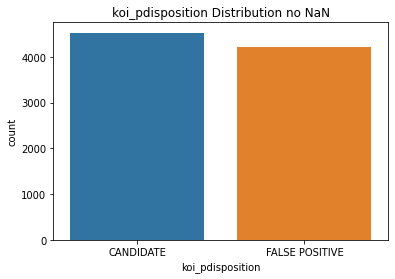

In [ ]:
sns.countplot(kp_drop['koi_pdisposition'])
plt.title('koi_pdisposition Distribution no NaN')
plt.show

The distribution of false positives to candidates is still close to even after removing rows with missing data.  This suggests balance, and better chances of a generalized model.

Find highly correlated variables. For this project, we'll set this at an absolute correlation coefficient greater than or equal to 0.70.

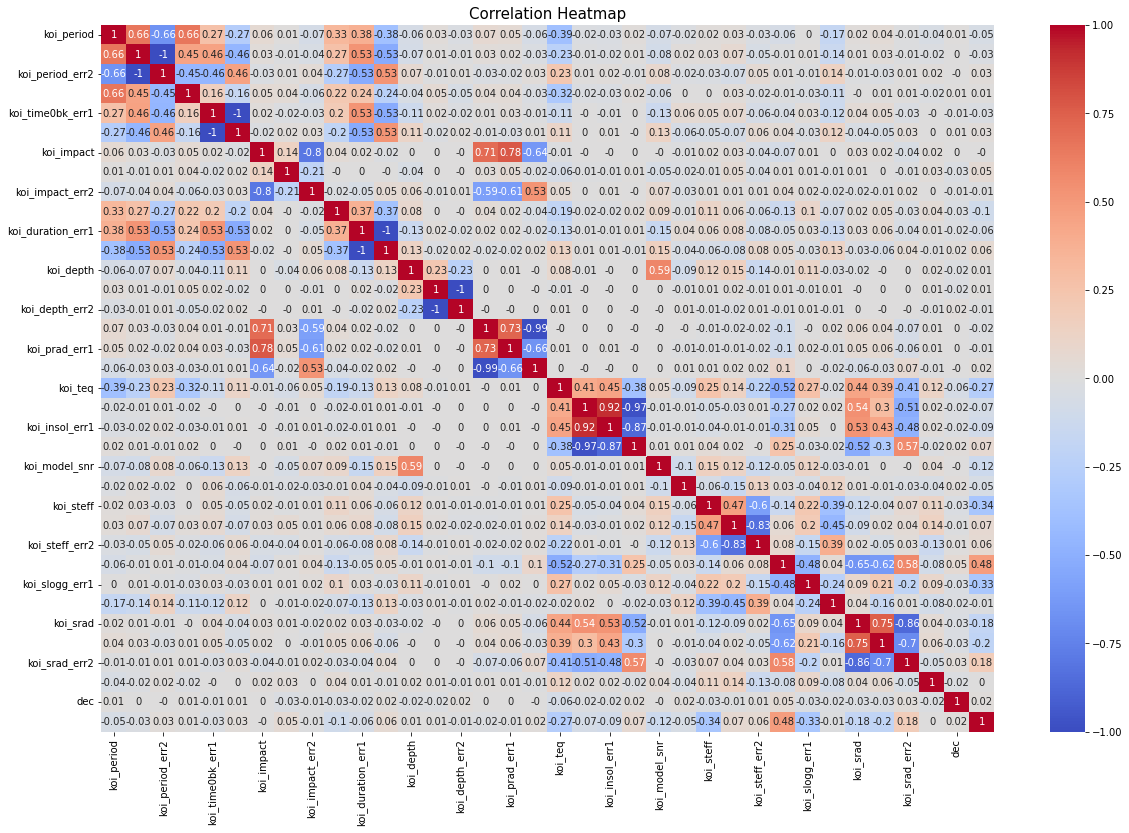

In [ ]:
matrix = kp_drop.corr().round(2)
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=15)
plt.gcf().set_size_inches(20, 13)
plt.show()

In [ ]:
# let's list these high correlation values
matrix = kp_drop.corr()
matrix = matrix.unstack()
matrix = matrix[abs(matrix) >= 0.7]
matrix = matrix[matrix != 1]
matrix = matrix[matrix != -1]

print(matrix)

koi_impact       koi_impact_err2   -0.803663
                 koi_prad           0.710456
                 koi_prad_err1      0.780784
koi_impact_err2  koi_impact        -0.803663
koi_prad         koi_impact         0.710456
                 koi_prad_err1      0.725682
                 koi_prad_err2     -0.988068
koi_prad_err1    koi_impact         0.780784
                 koi_prad           0.725682
koi_prad_err2    koi_prad          -0.988068
koi_insol        koi_insol_err1     0.917568
                 koi_insol_err2    -0.965981
koi_insol_err1   koi_insol          0.917568
                 koi_insol_err2    -0.870049
koi_insol_err2   koi_insol         -0.965981
                 koi_insol_err1    -0.870049
koi_steff_err1   koi_steff_err2    -0.825551
koi_steff_err2   koi_steff_err1    -0.825551
koi_srad         koi_srad_err1      0.754008
                 koi_srad_err2     -0.857725
koi_srad_err1    koi_srad           0.754008
koi_srad_err2    koi_srad          -0.857725
dtype: flo

Matrix variables may be removed for some of our models to avoid multicollinearity.

In [ ]:
# IDing variables that may be removed to avoid multicollinearity
multicol_candidates = kp_drop.corr().where(np.triu(np.ones(kp_drop.corr().shape),k=1).astype(bool))
multicol_drop = [column for column in multicol_candidates.columns if any(abs(multicol_candidates[column]) >= 0.70)]
print('The multicollinearity candidates to drop are:')
list(multicol_drop)

The multicollinearity candidates to drop are:


['koi_period_err2',
 'koi_time0bk_err2',
 'koi_impact_err2',
 'koi_duration_err2',
 'koi_depth_err2',
 'koi_prad',
 'koi_prad_err1',
 'koi_prad_err2',
 'koi_insol_err1',
 'koi_insol_err2',
 'koi_steff_err2',
 'koi_srad_err1',
 'koi_srad_err2']

In [ ]:
len(multicol_drop)

13

For some models, we may drop an additional 13 variables to avoid multicollinearity.

## Modeling

### Train and Test

In [ ]:
#define the X and y:
y = kp_drop['koi_pdisposition']
X = pd.DataFrame(kp_drop.drop(kp_drop[['koi_pdisposition']], axis = 1))

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2, random_state=5)
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(6995, 36)
(6995,)
(1749, 36)
(1749,)


In [ ]:
Xtest.dtypes

koi_period           float64
koi_period_err1      float64
koi_period_err2      float64
koi_time0bk          float64
koi_time0bk_err1     float64
koi_time0bk_err2     float64
koi_impact           float64
koi_impact_err1      float64
koi_impact_err2      float64
koi_duration         float64
koi_duration_err1    float64
koi_duration_err2    float64
koi_depth            float64
koi_depth_err1       float64
koi_depth_err2       float64
koi_prad             float64
koi_prad_err1        float64
koi_prad_err2        float64
koi_teq              float64
koi_insol            float64
koi_insol_err1       float64
koi_insol_err2       float64
koi_model_snr        float64
koi_tce_plnt_num     float64
koi_steff            float64
koi_steff_err1       float64
koi_steff_err2       float64
koi_slogg            float64
koi_slogg_err1       float64
koi_slogg_err2       float64
koi_srad             float64
koi_srad_err1        float64
koi_srad_err2        float64
ra                   float64
dec           

In [ ]:
sns.countplot(ytrain['koi_pdisposition'])
plt.title('koi_pdisposition Distribution Train Data')
plt.show

NameError: ignored

### Models

#### Linear Models

##### Perceptron

Modify the labels so they are plus and minus

In [ ]:
le = LabelEncoder()
ytrain_perc = le.fit_transform(ytrain)
ytrain_perc[ytrain_perc==0] = -1
ytrain_perc = pd.DataFrame(ytrain_perc)
ytrain_perc

,0
0,1
1,-1
2,-1
3,-1
4,1
...,...
6990,1
6991,1
6992,1
6993,-1


In [ ]:
le = LabelEncoder()
ytest_perc = le.fit_transform(ytest)
ytest_perc[ytest_perc==0] = -1
ytest_perc = pd.DataFrame(ytest_perc)
ytest_perc

,0
0,-1
1,-1
2,1
3,-1
4,-1
...,...
1744,1
1745,1
1746,-1
1747,1


Fit the model:

In [ ]:
#model using defaults
perc = Perceptron().fit(Xtrain, ytrain_perc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
perc_cm = confusion_matrix(ytest_perc, perc.predict(Xtest))
disposition_labels = {'False Positive', 'Candidate'}
pd.DataFrame(perc_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,562,326
Candidate,224,637


In [ ]:
pred_labels = perc.predict(Xtest)
actual_labels = np.array(ytest_perc)
#ytest_probs = perc.predict(Xtest)[:,1]
perc_acc = float(accuracy_score(actual_labels, pred_labels))*100

#print("AUC:", float(roc_auc_score(ytest_perc, ytest_probs)))
print('Accuracy:', float(accuracy_score(actual_labels, pred_labels))*100, '%')
print('Classification Stats:')
print(classification_report(actual_labels, pred_labels))

Accuracy: 68.55345911949685 %
Classification Stats:
              precision    recall  f1-score   support

          -1       0.72      0.63      0.67       888
           1       0.66      0.74      0.70       861

    accuracy                           0.69      1749
   macro avg       0.69      0.69      0.68      1749
weighted avg       0.69      0.69      0.68      1749



In [ ]:
#look for the best parameters:
params = {'max_iter': [1, 5, 10, 50, 100, 1000]}

perc1 = GridSearchCV(Perceptron(), params, cv=5, n_jobs=2, scoring='accuracy')
perc1.fit(Xtrain, ytrain_perc)
print('Perceptron parameters: ', perc1.best_params_)

Perceptron parameters:  {'max_iter': 5}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [ ]:
#fit the best model:
perc2 = LogisticRegression(max_iter=5)
perc2.fit(Xtrain, ytrain_perc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=5)

In [ ]:
perc2_cm = confusion_matrix(ytest_perc, perc2.predict(Xtest))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(perc2_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,854,34
Candidate,460,401


In [ ]:
pred_labels = perc2.predict(Xtest)
actual_labels = np.array(ytest_perc)

print('Accuracy:', float(accuracy_score(actual_labels, pred_labels))*100, '%')
print('Classification Stats:')
print(classification_report(actual_labels, pred_labels))

Accuracy: 71.75528873642081 %
Classification Stats:
              precision    recall  f1-score   support

          -1       0.65      0.96      0.78       888
           1       0.92      0.47      0.62       861

    accuracy                           0.72      1749
   macro avg       0.79      0.71      0.70      1749
weighted avg       0.78      0.72      0.70      1749



##### Logistic Regression

This model will require more preprocessing, such as centering, scaling, and removing predictors with near zero variance.

In [ ]:
#Remove predictors with near zero variance (NZV):
threshold_n=0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(Xtrain)
Xtrain_NZV = Xtrain[Xtrain.columns[sel.get_support(indices=True)]]
print(Xtrain_NZV.shape)

threshold_n=0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(Xtest)
Xtest_NZV = Xtest[Xtest.columns[sel.get_support(indices=True)]]
print(Xtest_NZV.shape)

(6995, 30)
(1749, 30)


In [ ]:
#Remove highly correlated predictors:
multicol_candidates = Xtrain_NZV.corr().where(np.triu(np.ones(Xtrain_NZV.corr().shape),k=1).astype(bool))
multicol_drop = [column for column in multicol_candidates.columns if any(abs(multicol_candidates[column]) >= 0.70)]
Xtrain_NZV_corr = Xtrain_NZV.drop(multicol_drop, axis=1)
Xtest_NZV_corr = Xtest_NZV.drop(multicol_drop, axis=1)

In [ ]:
#Center the predictor:
norm_X = Normalizer()
norm_X.fit(Xtrain_NZV_corr)
Xtrain_NZV_corr_norm = norm_X.transform(Xtrain_NZV_corr)
Xtest_NZV__corr_norm = norm_X.transform(Xtest_NZV_corr)

In [ ]:
#Scale the predictor data:
sc_X = StandardScaler()
sc_X.fit(Xtrain_NZV_corr_norm)
Xtrain_NZV_corr_norm_sc = sc_X.transform(Xtrain_NZV_corr_norm)
Xtest_NZV__corr_norm_sc = sc_X.transform(Xtest_NZV__corr_norm)
Xtrain_lr = Xtrain_NZV_corr_norm_sc
Xtest_lr = Xtest_NZV__corr_norm_sc

In [ ]:
#fit the logistic regression model using the default params on the preprocessed training data:
logreg = LogisticRegression(random_state=5).fit(Xtrain_lr, ytrain)

In [ ]:
#check performance on the test data set:
logreg_cm = confusion_matrix(ytest, logreg.predict(Xtest_lr))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(logreg_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,758,130
Candidate,190,671


In [ ]:
pred_labels = logreg.predict(Xtest_lr)
actual_labels = np.array(ytest)
ytest_probs = logreg.predict_proba(Xtest_lr)[:,1]

print("AUC:", float(roc_auc_score(ytest, ytest_probs)))
print('Accuracy:', float(accuracy_score(actual_labels, pred_labels))*100, '%')
print('Classification Stats:')
print(classification_report(actual_labels, pred_labels))

AUC: 0.9019838653984996
Accuracy: 81.70383076043454 %
Classification Stats:
                precision    recall  f1-score   support

     CANDIDATE       0.80      0.85      0.83       888
FALSE POSITIVE       0.84      0.78      0.81       861

      accuracy                           0.82      1749
     macro avg       0.82      0.82      0.82      1749
  weighted avg       0.82      0.82      0.82      1749



In [ ]:
#look for the best parameters:
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'fit_intercept':[True, False]}

logreg1 = GridSearchCV(LogisticRegression(), params, cv=5, n_jobs=2, scoring='roc_auc')
logreg1.fit(Xtrain_lr, ytrain)
print('Logistic Regression parameters: ', logreg1.best_params_)

Logistic Regression parameters:  {'C': 1000, 'fit_intercept': True}


In [ ]:
#fit the best model:
logreg2 = LogisticRegression(C = 1000, fit_intercept= True)
logreg2.fit(Xtrain_lr, ytrain)

LogisticRegression(C=1000)

In [ ]:
logreg2_cm = confusion_matrix(ytest, logreg2.predict(Xtest_lr))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(logreg2_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,759,129
Candidate,190,671


In [ ]:
pred_labels = logreg2.predict(Xtest_lr)
actual_labels = np.array(ytest)
ytest_probs = logreg.predict_proba(Xtest_lr)[:,1]
logreg_acc = float(accuracy_score(actual_labels, pred_labels))*100

print("AUC:", float(roc_auc_score(ytest, ytest_probs)))
print('Accuracy:', float(accuracy_score(actual_labels, pred_labels))*100, '%')
print('Classification Stats:')
print(classification_report(actual_labels, pred_labels))

AUC: 0.9019838653984996
Accuracy: 81.76100628930818 %
Classification Stats:
                precision    recall  f1-score   support

     CANDIDATE       0.80      0.85      0.83       888
FALSE POSITIVE       0.84      0.78      0.81       861

      accuracy                           0.82      1749
     macro avg       0.82      0.82      0.82      1749
  weighted avg       0.82      0.82      0.82      1749



#####Support Vector Machine

Requires Centering and scaling of the test/train data

In [ ]:
#Center the predictor:
norm_X = Normalizer()
norm_X.fit(Xtrain)
Xtrain_norm = norm_X.transform(Xtrain)
Xtest_norm = norm_X.transform(Xtest)

In [ ]:
#Scale the predictor data:
sc_X = StandardScaler()
sc_X.fit(Xtrain_norm)
Xtrain_norm_sc = sc_X.transform(Xtrain_norm)
Xtest_norm_sc = sc_X.transform(Xtest_norm)
Xtrain_svm = Xtrain_norm_sc
Xtest_svm = Xtest_norm_sc

In [ ]:
#build model based on default parameters and a linear kernel:
svm = SVC(kernel='linear')
svm.fit(Xtrain_svm, ytrain)

SVC(kernel='linear')

In [ ]:
#check performance on the test data set:
svm_cm = confusion_matrix(ytest, svm.predict(Xtest_svm))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(svm_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,771,117
Candidate,169,692


In [ ]:
accuracy_score(ytest, svm.predict(Xtest_svm))

0.8364779874213837

In [ ]:
# Finding the best hyperparameters
params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svm1 = GridSearchCV(estimator=SVC(), param_grid=params, cv=5, n_jobs=5, verbose=1)

svm1.fit(Xtrain_svm, ytrain)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

In [ ]:
svm1.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
#fit the best model:
svm2 = SVC(kernel='rbf', gamma=0.001, C = 1000)
svm2.fit(Xtrain_svm, ytrain)

SVC(C=1000, gamma=0.001)

In [ ]:
svm2_cm = confusion_matrix(ytest, svm2.predict(Xtest_svm))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(svm2_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,774,114
Candidate,147,714


In [ ]:
pred_labels = svm2.predict(Xtest_svm)
actual_labels = np.array(ytest)
SVM_acc = float(accuracy_score(actual_labels, pred_labels))*100

print('Accuracy:', float(accuracy_score(actual_labels, pred_labels))*100, '%')
print('Classification Stats:')
print(classification_report(actual_labels, pred_labels))

Accuracy: 85.07718696397941 %
Classification Stats:
                precision    recall  f1-score   support

     CANDIDATE       0.84      0.87      0.86       888
FALSE POSITIVE       0.86      0.83      0.85       861

      accuracy                           0.85      1749
     macro avg       0.85      0.85      0.85      1749
  weighted avg       0.85      0.85      0.85      1749



##### Stochastic Gradient Descent (SGD)

In [ ]:
#We'll use the scaled data for this model
#Scale the predictor data:
sc_X = StandardScaler()
sc_X.fit(Xtrain)
Xtrain_sc = sc_X.transform(Xtrain)
Xtest_sc = sc_X.transform(Xtest)
Xtrain_sgd = Xtrain_sc
Xtest_sgd = Xtest_sc

In [ ]:
#fit the default model:
sgd = SGDClassifier()
sgd.fit(Xtrain_sc, ytrain)

SGDClassifier()

In [ ]:
#check performance on the test data set:
sgd_cm = confusion_matrix(ytest, svm.predict(Xtest_sgd))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(sgd_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,586,302
Candidate,356,505


In [ ]:
accuracy_score(ytest, sgd.predict(Xtest_sgd))

0.8164665523156089

In [ ]:
#now check for the best hyperparameters:
# Finding the best hyperparameters
params = {
    'loss': ['log_loss', 'modified_huber', 'hinge'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
    'max_iter': [1, 5, 10, 50, 100, 1000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

sgd1 = GridSearchCV(estimator=SGDClassifier(), param_grid=params, cv=5, n_jobs=5, verbose=1)

sgd1.fit(Xtrain_sgd, ytrain)


In [ ]:
print(sgd1.best_params_)

{'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 100}


In [ ]:
#fit the best model:
sgd2 = SGDClassifier(alpha= 0.001, learning_rate= 'optimal', loss='hinge', max_iter=100)
sgd2.fit(Xtrain_sgd, ytrain)

SGDClassifier(alpha=0.001, max_iter=100)

In [ ]:
sgd2_cm = confusion_matrix(ytest, sgd2.predict(Xtest_sgd))
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(sgd2_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,795,93
Candidate,199,662


In [ ]:
pred_labels = sgd2.predict(Xtest_sgd)
actual_labels = np.array(ytest)
SGD_acc = float(accuracy_score(actual_labels, pred_labels))*100

print('Accuracy:', float(accuracy_score(actual_labels, pred_labels))*100, '%')
print('Classification Stats:')
print(classification_report(actual_labels, pred_labels))

Accuracy: 83.30474556889651 %
Classification Stats:
                precision    recall  f1-score   support

     CANDIDATE       0.80      0.90      0.84       888
FALSE POSITIVE       0.88      0.77      0.82       861

      accuracy                           0.83      1749
     macro avg       0.84      0.83      0.83      1749
  weighted avg       0.84      0.83      0.83      1749



#### Nonlinear Models

##### KNN

In [ ]:
# let's preprocess our target variables by converting to binary output
le = LabelEncoder()

# target train
ytrain_knn = le.fit_transform(ytrain)
ytrain_knn = pd.DataFrame(ytrain_knn)

# target test
ytest_knn = le.fit_transform(ytest)
ytest_knn = pd.DataFrame(ytest_knn)

In [ ]:
# define k_neighbors
def k_neighbors(Xtrain, ytrain, Xtest, ytest, kvalues, metric): 
  knn_accuracy = []
  clfs = []
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(Xtrain, ytrain)
    clf_train_pred = clf.predict(Xtrain)
    clf_test_pred = clf.predict(Xtest)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, ytrain),
    'Test Accuracy': accuracy_score(clf_test_pred, ytest)})
  return pd.DataFrame(knn_accuracy), clfs

###### KNN - Euclidean

In [ ]:
# let's check performance using euclidean metric
knn_euc_acc, knn_euc_clfs = k_neighbors(Xtrain, ytrain, Xtest, ytest, range(1,15), metric='euclidean')
display(knn_euc_acc)

,k values,Training Accuracy,Test Accuracy
0,1,1.000000,0.739280
1,2,0.864332,0.736993
2,3,0.873052,0.763865
3,4,0.837312,0.761578
4,5,0.843888,0.762150
5,6,0.822731,0.762722
6,7,0.825447,0.781589
7,8,0.816297,0.775872
8,9,0.818156,0.783305
9,10,0.809149,0.778731


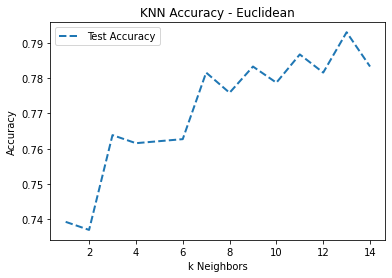

In [ ]:
# let's plot the test accuracy against k values to find optimal k
plt.plot(knn_euc_acc['k values'], knn_euc_acc['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - Euclidean')
plt.legend()
plt.show()

Looking at the test accuracy, K values after 7 provide minimal increases in test accuracy, so we will choose k=7.

In [ ]:
# let's apply best k=7
clf_knn_euc = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2)
clf_knn_euc.fit(Xtrain, ytrain)
knn_euc_pred = clf_knn_euc.predict(Xtest)

In [ ]:
# confusion matrix to see performance
knn_euc_cm = confusion_matrix(ytest, knn_euc_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(knn_euc_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,740,148
Candidate,234,627


In [ ]:
actual_labels = np.array(ytest)
euc_acc = float(accuracy_score(actual_labels, knn_euc_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, knn_euc_pred))*100, '%')

Accuracy: 78.15894797026873 %


###### KNN - Manhattan

In [ ]:
# let's check performance using manhattan distance
knn_man_acc, knn_man_clfs = k_neighbors(Xtrain, ytrain, Xtest, ytest, range(1,15), metric='manhattan')
display(knn_man_acc)

,k values,Training Accuracy,Test Accuracy
0,1,1.000000,0.751858
1,2,0.869192,0.745569
2,3,0.876340,0.772441
3,4,0.841315,0.759291
4,5,0.848177,0.780446
5,6,0.826162,0.778731
6,7,0.834167,0.795312
7,8,0.821873,0.790166
8,9,0.827162,0.800457
9,10,0.816440,0.789022


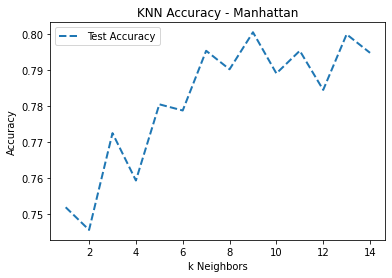

In [ ]:
# same thing, let's plot the test accuracy against k values to find optimal k
plt.plot(knn_man_acc['k values'], knn_man_acc['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - Manhattan')
plt.legend()
plt.show()

As with Euclidean distance, K values past 7 provide minimal increase in test accuracy, so k=7 will be used.

In [ ]:
# let's apply best k=7
clf_knn_man = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=1)
clf_knn_man.fit(Xtrain, ytrain)
knn_man_pred = clf_knn_man.predict(Xtest)

In [ ]:
# confusion matrix to see performance
knn_man_cm = confusion_matrix(ytest, knn_man_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(knn_man_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,745,143
Candidate,215,646


In [ ]:
man_acc = float(accuracy_score(actual_labels, knn_man_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, knn_man_pred))*100, '%')

Accuracy: 79.53116066323614 %


###### KNN - Cosine

In [ ]:
# let's check performance using cosine distance
knn_cos_acc, knn_cos_clfs = k_neighbors(Xtrain, ytrain, Xtest, ytest, range(1,15), metric='cosine')
display(knn_cos_acc)

,k values,Training Accuracy,Test Accuracy
0,1,1.000000,0.764437
1,2,0.862044,0.745569
2,3,0.868192,0.777015
3,4,0.838885,0.759863
4,5,0.839028,0.782161
5,6,0.818442,0.776444
6,7,0.822588,0.786164
7,8,0.815011,0.778159
8,9,0.815297,0.779302
9,10,0.809864,0.785592


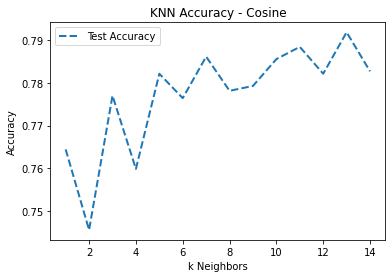

In [ ]:
# same thing, let's plot the test accuracy against k values to find optimal k
plt.plot(knn_cos_acc['k values'], knn_cos_acc['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - Cosine')
plt.legend()
plt.show()

As with both euclidean and manhattan distance, cosine distance shows minimal test accuracy improvements after K value of 7, so k=7 will be chosen.

In [ ]:
# let's apply best k=7
clf_knn_cos = KNeighborsClassifier(n_neighbors=7, metric='cosine')
clf_knn_cos.fit(Xtrain, ytrain)
knn_cos_pred = clf_knn_cos.predict(Xtest)

In [ ]:
# confusion matrix to see performance
knn_cos_cm = confusion_matrix(ytest, knn_cos_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(knn_cos_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,737,151
Candidate,223,638


In [ ]:
cos_acc = float(accuracy_score(actual_labels, knn_cos_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, knn_cos_pred))*100, '%')

Accuracy: 78.61635220125787 %


In terms of accuracy, KNN using Manhattan distance performed better and resulted in higher accuracy.

##### Decision Tree

In [ ]:
# let's preprocess our target variables by converting to binary output
# this is the same to what was done for the target in KNN analysis
le = LabelEncoder()

# target train
ytrain_knn = le.fit_transform(ytrain)
ytrain_knn = pd.DataFrame(ytrain_knn)

# target test
ytest_knn = le.fit_transform(ytest)
ytest_knn = pd.DataFrame(ytest_knn)

###### Decision Tree - Default

In [ ]:
# fit a default decision tree
clf_dt_default = tree.DecisionTreeClassifier()
clf_dt_default.fit(Xtrain, ytrain)
dt_default_pred = clf_dt_default.predict(Xtest)

In [ ]:
# confusion matrix to see performance
dt_default_cm = confusion_matrix(ytest, dt_default_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(dt_default_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,728,160
Candidate,188,673


In [ ]:
dt_def_acc = float(accuracy_score(actual_labels, dt_default_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, dt_default_pred))*100, '%')

Accuracy: 80.10291595197255 %


###### Decision Tree - Max Depth

In [ ]:
# let's fit a decision tree with optimal max depth
def dt(Xtrain, ytrain, Xtest, ytest, maxdepth): 
  dt_accuracy = []
  clfs_dt = []
  for i in maxdepth:
    clf_dt_depth = tree.DecisionTreeClassifier(max_depth=i).fit(Xtrain, ytrain)
    dt_depth_pred = clf_dt_depth.predict(Xtest)
    clfs_dt.append(clf_dt_depth)
    dt_accuracy.append({'max depth': i,
    'Test Accuracy': accuracy_score(dt_depth_pred, ytest)})
  return pd.DataFrame(dt_accuracy), clfs_dt

In [ ]:
# let's see test accuracy with a range of max depth from 1-15
dt_depth_acc, dt_depth_clfs = dt(Xtrain, ytrain, Xtest, ytest, range(1,15))
display(dt_depth_acc)

,max depth,Test Accuracy
0,1,0.734706
1,2,0.801029
2,3,0.802744
3,4,0.811321
4,5,0.821041
5,6,0.832476
6,7,0.826758
7,8,0.820469
8,9,0.833619
9,10,0.827330


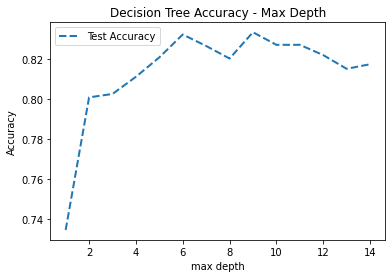

In [ ]:
# same thing, let's plot the test accuracy of varying max_depth values
plt.plot(dt_depth_acc['max depth'], dt_depth_acc['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy - Max Depth')
plt.legend()
plt.show()

Let's choose a max_depth=6 to fit our decision tree model. After max_depth=6, any increase in layers seems to reduce accuracy, possibly due to overfitting.

In [ ]:
# fit a max depth decision tree
clf_dt_depth = tree.DecisionTreeClassifier(max_depth=6)
clf_dt_depth.fit(Xtrain, ytrain)
dt_depth_pred = clf_dt_depth.predict(Xtest)

In [ ]:
# confusion matrix to see performance
dt_depth_cm = confusion_matrix(ytest, dt_depth_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(dt_depth_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,811,77
Candidate,218,643


In [ ]:
maxdepth_acc = float(accuracy_score(actual_labels, dt_depth_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, dt_depth_pred))*100, '%')

Accuracy: 83.13321898227558 %


Compared to our default decision tree, optimizing max_depth allowed our model to more accurately predict False Positives

###### Decision Tree - Cost Complexity Pruning

In [ ]:
# pruning will help to control the size of the tree w/o us using max_depth
# we'll define this based off of our default decision tree
path = clf_dt_default.cost_complexity_pruning_path(Xtrain, ytrain)
ccp_alphas = path.ccp_alphas
# higher alpha = more of the tree is pruned

In [ ]:
# let's plot the alphas
def dt_prune(Xtrain, ytrain, Xtest, ytest, ccp_alphas): 
  dt_accuracy = []
  clfs_dt_pruned = []
  for i in ccp_alphas:
    clf_dt_pruned_tree = tree.DecisionTreeClassifier(ccp_alpha=i).fit(Xtrain, ytrain)
    dt_prune_pred = clf_dt_pruned_tree.predict(Xtest)
    clfs_dt_pruned.append(clf_dt_pruned_tree)
    dt_accuracy.append({'alphas': i,
    'Test Accuracy': accuracy_score(dt_prune_pred, ytest)})
  return pd.DataFrame(dt_accuracy).head(15), clfs_dt_pruned

In [ ]:
# let's see test accuracy with a range of alpha values
dt_prune_acc, dt_prune_clfs = dt_prune(Xtrain, ytrain, Xtest, ytest, ccp_alphas)
display(dt_prune_acc)

,alphas,Test Accuracy
0,0.000000,0.801029
1,0.000095,0.808462
2,0.000113,0.792453
3,0.000130,0.805603
4,0.000133,0.804460
5,0.000135,0.799886
6,0.000136,0.801029
7,0.000136,0.798170
8,0.000137,0.803888
9,0.000137,0.814180


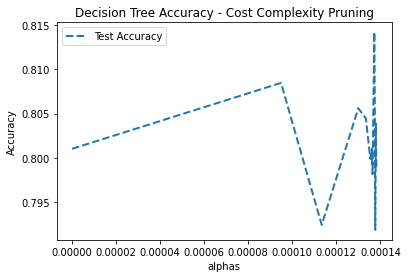

In [ ]:
# same thing, let's plot the test accuracy of varying alpha values
plt.plot(dt_prune_acc['alphas'], dt_prune_acc['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('alphas')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy - Cost Complexity Pruning')
plt.legend()
plt.show()

ccp_alpha = 0.000135 gives the most accuracy before dropping

In [ ]:
# fit a ccp decision tree
clf_dt_prune = tree.DecisionTreeClassifier(ccp_alpha=0.000135)
clf_dt_prune.fit(Xtrain, ytrain)
dt_prune_pred = clf_dt_prune.predict(Xtest)

In [ ]:
# confusion matrix to see performance
dt_prune_cm = confusion_matrix(ytest, dt_prune_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(dt_prune_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,730,158
Candidate,187,674


In [ ]:
ccp_acc = float(accuracy_score(actual_labels, dt_prune_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, dt_prune_pred))*100, '%')

Accuracy: 80.27444253859348 %


Amongst the decision trees, the one tuned using max_depth gave the model with the highest test accuracy.

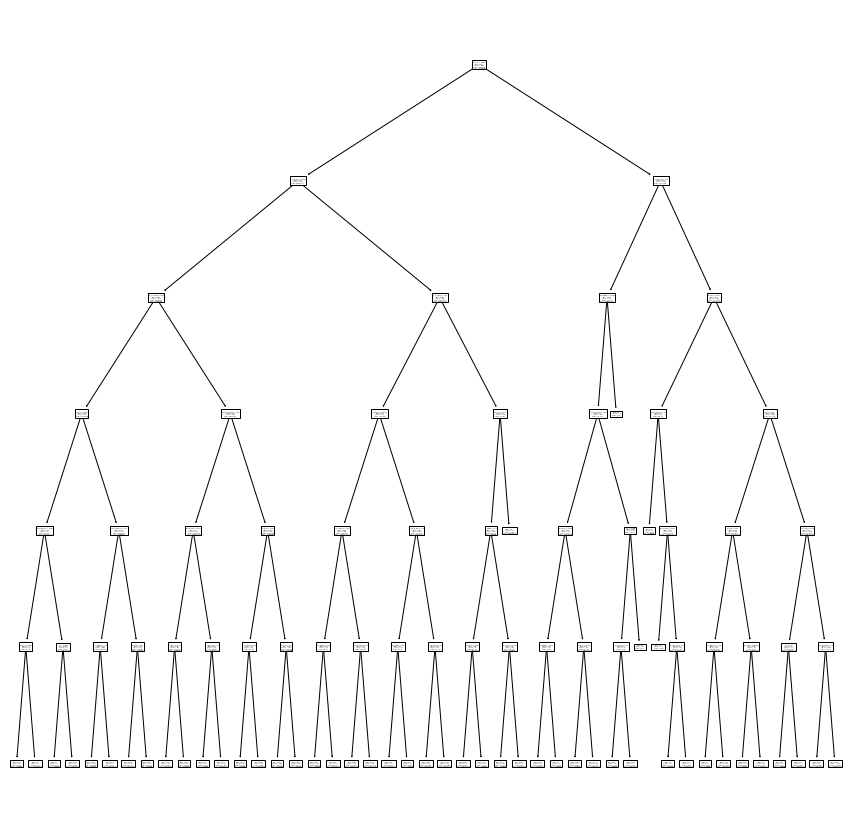

In [ ]:
# plot the max_depth decision tree
fig,ax = plt.subplots(figsize = (15,15))
treeplot = tree.plot_tree(clf_dt_depth, feature_names=list(X.columns), class_names = ['Candidate', 'False Positive'], ax=ax)

##### PCA on Random Forest

In [ ]:
# first, let's normalize our variables
sc = StandardScaler()
X_train = sc.fit_transform(Xtrain)
X_test = sc.transform(Xtest)

In [ ]:
# perform PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# let's see how much of the variance is explained
explained_var = pca.explained_variance_ratio_

In [ ]:
# let's use random forest
clf_PCA_rf = RandomForestClassifier()
clf_PCA_rf.fit(X_train, ytrain)
PCA_rf_pred = clf_PCA_rf.predict(X_test)

In [ ]:
# confusion matrix to see performance
PCA_rf_cm = confusion_matrix(ytest, PCA_rf_pred)
disposition_labels = {'Candidate', 'False Positive'}
pd.DataFrame(PCA_rf_cm, index = disposition_labels, columns= disposition_labels)

,False Positive,Candidate
False Positive,749,139
Candidate,130,731


In [ ]:
pca_acc = float(accuracy_score(actual_labels, PCA_rf_pred))*100
print('Accuracy:', float(accuracy_score(actual_labels, PCA_rf_pred))*100, '%')

Accuracy: 84.61978273299027 %


### Model Analysis

In [ ]:
print('Accuracy of Perceptron is:', perc_acc, '%')
print('Accuracy of Logistic Regression is:', logreg_acc, '%')
print('Accuracy of SVM is:', SVM_acc, '%')
print('Accuracy of SGD is:', SGD_acc, '%')
print('Accuracy of KNN Using Euclidean Distance is:', euc_acc, '%')
print('Accuracy of KNN Using Manhattan Distance is:', man_acc, '%')
print('Accuracy of KNN Using Cosine Distance is:', cos_acc, '%')
print('Accuracy of the Default Decision Tree is:', dt_def_acc, '%')
print('Accuracy of Decision Tree with Optimized Max Depth is:', maxdepth_acc, '%')
print('Accuracy of CCP Decision Tree is:', ccp_acc, '%')
print('Accuracy of Random Forest Using PCA is:', pca_acc, '%')

Accuracy of Perceptron is: 68.55345911949685 %
Accuracy of Logistic Regression is: 81.76100628930818 %
Accuracy of SVM is: 85.07718696397941 %
Accuracy of SGD is: 83.30474556889651 %
Accuracy of KNN Using Euclidean Distance is: 78.15894797026873 %
Accuracy of KNN Using Manhattan Distance is: 79.53116066323614 %
Accuracy of KNN Using Cosine Distance is: 78.61635220125787 %
Accuracy of the Default Decision Tree is: 80.10291595197255 %
Accuracy of Decision Tree with Optimized Max Depth is: 83.13321898227558 %
Accuracy of CCP Decision Tree is: 80.27444253859348 %
Accuracy of Random Forest Using PCA is: 84.61978273299027 %
